In [1]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
random_value = 42
random.seed(random_value)
np.random.seed(random_value)

In [3]:
class CreateSampleDataset():
    def __init__(self, n_teachers=1000, school_teacher_ratio=1.05, teacher_per_school=15.,
                 std_dev_teacher_per_school=3., min_teachers_per_school=5, p_rural=0.3, p_car=0.7, p_experienced=0.7):
        self.n_teachers = n_teachers
        self.n_schools = int(n_teachers * school_teacher_ratio / teacher_per_school)
        self.teacher_per_school = teacher_per_school
        self.std_dev_teacher_per_school = std_dev_teacher_per_school
        self.min_teachers_per_school = min_teachers_per_school
        self.p_rural = p_rural
        self.p_car = p_car
        self.p_experienced = p_experienced

    def _createTeachers(self):
        x_location = np.random.uniform(0., 1., self.n_teachers)
        y_location = np.random.uniform(0., 1., self.n_teachers)
        rural = np.random.choice([0, 1], p=[1 - self.p_rural, self.p_rural], size=self.n_teachers)
        car = np.random.choice([0, 1], p=[1 - self.p_car, self.p_car], size=self.n_teachers)
        experienced = np.random.choice([0, 1], p=[1 - self.p_experienced, self.p_experienced], size=self.n_teachers)
        teachers = {'x_location': x_location,
                    'y_location': y_location,
                    'rural': rural,
                    'car': car,
                    'experience': experienced,
                    }

        return teachers

    def _createSchools(self):
        x_location = np.random.uniform(0., 1., self.n_schools)
        y_location = np.random.uniform(0., 1., self.n_schools)
        rural = np.random.choice([0, 1], p=[1 - self.p_rural, self.p_rural], size=self.n_schools)
        n_teachers = np.random.normal(loc=self.teacher_per_school, scale=self.std_dev_teacher_per_school, size=self.n_schools).astype(int)
        n_teachers_clipped = np.clip(n_teachers, a_min=self.min_teachers_per_school, a_max=None, out=n_teachers)
        schools = {'ID': range(self.n_schools),
                   'x_location': x_location,
                   'y_location': y_location,
                   'rural': rural,
                   'n_teachers': n_teachers_clipped,
                   }

        return schools

    def make_dataset(self):
        teachers = pd.DataFrame(self._createTeachers())
        schools = pd.DataFrame(self._createSchools())

        return teachers, schools

In [4]:
DatasetSampler = CreateSampleDataset()

In [5]:
teachers, schools = DatasetSampler.make_dataset()

In [6]:
teachers.head()

,x_location,y_location,rural,car,experience
0,0.374540,0.185133,0,1,1
1,0.950714,0.541901,0,1,1
2,0.731994,0.872946,1,0,1
3,0.598658,0.732225,0,1,0
4,0.156019,0.806561,0,1,0


In [7]:
schools.head()

,ID,x_location,y_location,rural,n_teachers
0,0,0.393636,0.552815,0,18
1,1,0.473436,0.740664,0,12
2,2,0.854547,0.485018,0,19
3,3,0.340004,0.085403,1,10
4,4,0.869650,0.972461,0,19


In [8]:
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

school_per_cluster = 5
n_iterations = 100
min_differences = []
variances = []

# Finding the best random seed for kmeans
for i in range(n_iterations):
    # Kmeans for School-to-Cluster
    X_train = np.array(schools[['x_location', 'y_location']])
    labels = [i for i in range((DatasetSampler.n_schools // school_per_cluster))]
    kmeans = KMeans(n_clusters=(DatasetSampler.n_schools // school_per_cluster), random_state=i)
    preds = kmeans.fit_predict(X_train, labels)
    means = kmeans.cluster_centers_
    cluster_labels = kmeans.labels_
    schools['cluster'] = cluster_labels
    
    # KNN for Teacher-to-Cluster
    knn = KNeighborsClassifier(n_neighbors=1)
    X_train = np.array(schools[['x_location', 'y_location']])
    X_train = means
    y_train = labels
    knn.fit(X_train, y_train)
    X_test = np.array(teachers[['x_location', 'y_location']])
    preds = knn.predict(X_test)
    teachers['cluster'] = preds
    
    # Apply Metric
    teacher_demand = schools.groupby(by='cluster')['n_teachers'].sum()
    teacher_supply = teachers.groupby(by='cluster')['x_location'].count()
    teachers_difference = teacher_supply - teacher_demand
    teachers_difference_pct = teachers_difference / teacher_demand
    min_difference = min(teachers_difference_pct)
    min_differences.append(min_difference)
    variances.append(teachers_difference_pct.std()**2)
    

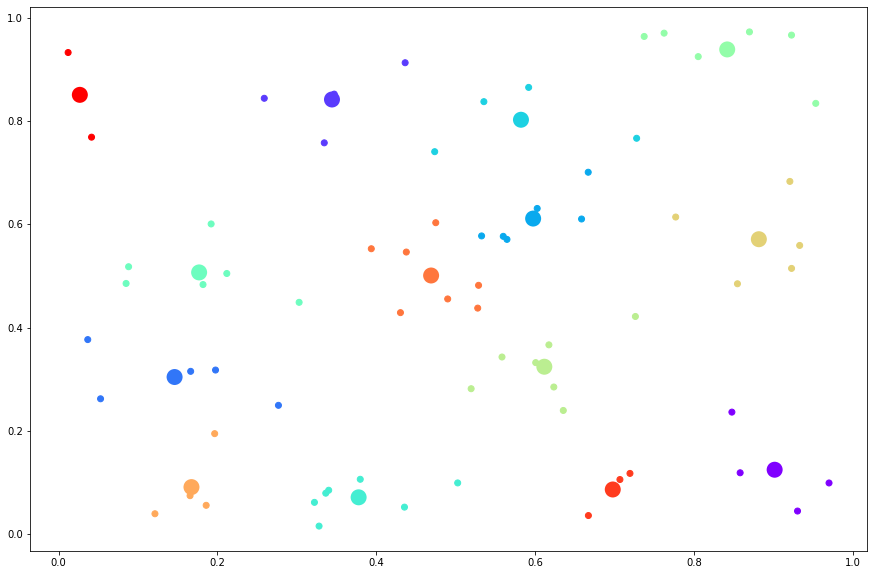

In [15]:
# Do optimized run
best_iteration = np.argmax(np.array(min_differences))
#best_iteration = np.argmin(np.array(variances))
X_train = np.array(schools[['x_location', 'y_location']])
labels = [i for i in range((DatasetSampler.n_schools // school_per_cluster))]
kmeans = KMeans(n_clusters=(DatasetSampler.n_schools // school_per_cluster), random_state=best_iteration)
preds = kmeans.fit_predict(X_train, labels)
means = kmeans.cluster_centers_
schools['cluster'] = preds

plt.figure(figsize=(15,10))
plt.scatter(X_train[:, 0], X_train[:, 1], c=preds, cmap='rainbow')
plt.scatter(means[:, 0], means[:, 1], c=labels, linewidth=10., cmap='rainbow')

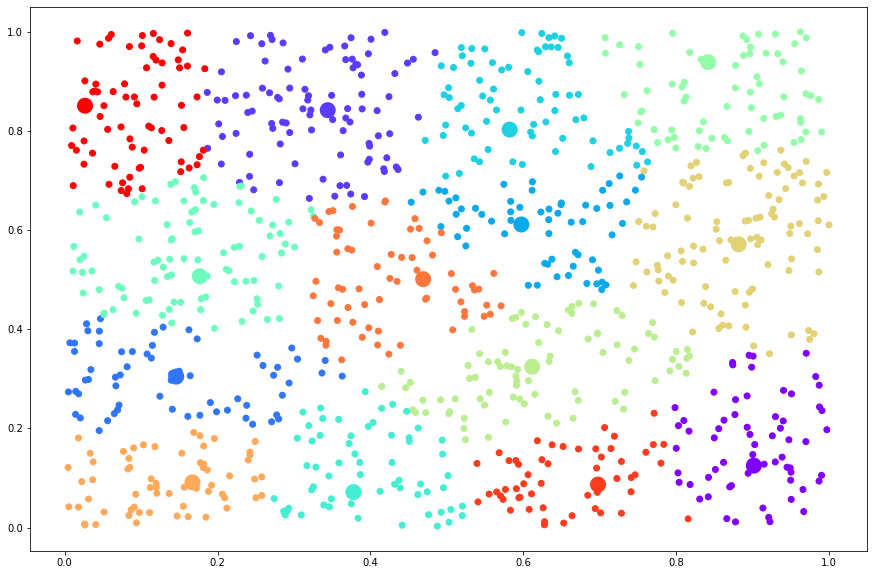

In [16]:
# KNN for Teacher-to-Cluster
knn = KNeighborsClassifier(n_neighbors=1)
X_train = np.array(schools[['x_location', 'y_location']])
X_train = means
y_train = labels
knn.fit(X_train, y_train)
X_test = np.array(teachers[['x_location', 'y_location']])
preds = knn.predict(X_test)
teachers['cluster'] = preds

plt.figure(figsize=(15,10))
plt.scatter(X_test[:, 0], X_test[:, 1], c=preds, cmap='rainbow')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, linewidth=10., cmap='rainbow')

In [17]:
# Fill DataFrame
cluster_df = pd.DataFrame({
                           'Cluster ID': labels,
                           'teacher_demand': schools.groupby(by='cluster')['n_teachers'].sum(),
                           'teacher_supply': teachers.groupby(by='cluster')['x_location'].count(),
                           })
cluster_df['teachers_difference'] = cluster_df['teacher_supply'] - cluster_df['teacher_demand']
cluster_df['teachers_difference_pct'] = cluster_df['teachers_difference'] / cluster_df['teacher_demand']

/opt/anaconda3/envs/torch/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


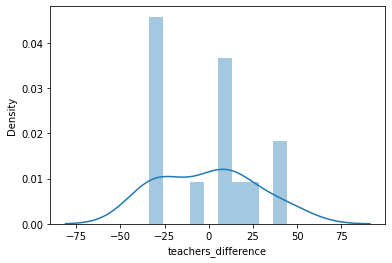

In [18]:
# Absolute Difference
sns.distplot(cluster_df['teachers_difference'], bins=10)

/opt/anaconda3/envs/torch/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


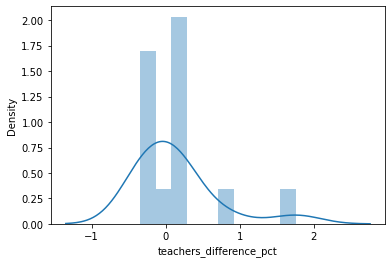

In [19]:
# Relative difference
sns.distplot(cluster_df['teachers_difference_pct'], bins=10)

/opt/anaconda3/envs/torch/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


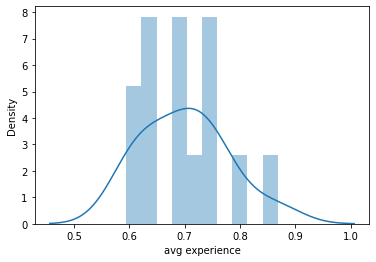

In [20]:
# Get avg experience (is center around 0.7 see class)
cluster_df['avg experience'] = teachers.groupby(by='cluster')['experience'].mean()
sns.distplot(cluster_df['avg experience'], bins=10)